In [1]:
from astropy import coordinates
from PIL import Image
import numpy as np
from astropy import io
import reproject
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import xarray as xr
from scipy.ndimage import morphology
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator, interp2d, LinearNDInterpolator
from tqdm import tqdm
from astropy import wcs
from astropy.utils.data import download_file
from reproject import reproject_interp
import glob

OK, let's build a png that goes over some range of l and b

In [2]:
lmin = 9
lmax = 40
bmin = -0.8
bmax = 0.8
dpix = 2.0 # arcseconds
ny = int((bmax-bmin)*3600/dpix)
nx = int((lmax-lmin)*3600/dpix)
img_array = np.zeros([ny,nx])

Want to make this into a HDU so that I can use reproject

In [3]:
hduimg = io.fits.PrimaryHDU(img_array)
hduimg.header['CTYPE1']='GLON-SIN'
hduimg.header['CTYPE2']='GLAT-SIN'

hduimg.header['CRVAL1']= 0.5*(lmin+lmax)
hduimg.header['CRPIX1']= nx/2.0
hduimg.header['CROTA1']= 0
hduimg.header['CDELT1']= -1*dpix/3600.

hduimg.header['CRVAL2']= 0.0
hduimg.header['CRPIX2']= ny/2.0
hduimg.header['CROTA2']= 0
hduimg.header['CDELT2']= 1*dpix/3600.

hduimg.header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                55800                                                  
NAXIS2  =                 2880                                                  
EXTEND  =                    T                                                  
CTYPE1  = 'GLON-SIN'                                                            
CTYPE2  = 'GLAT-SIN'                                                            
CRVAL1  =                 24.5                                                  
CRPIX1  =              27900.0                                                  
CROTA1  =                    0                                                  
CDELT1  = -0.00055555555555555                                                  
CRVAL2  =                  0

OK, let's try to populate the above with data from MAGPIS

In [4]:
from astropy.io import ascii
tab = ascii.read('gps20new_fldinfo.list')
print(tab)

 Name  UserID Dsk Cat#     Long        Lat      NX   NY   PixSize       Freq    
------ ------ --- ---- ----------- ----------- ---- ---- ---------- ------------
070-00    114   3    1  7.32028191 -0.22416725 8192 2048 2.00000005 1410000000.0
070+00    114   3    2  7.32028145  0.20194487 8192 2048 2.00000005 1410000000.0
110-00    114   3    3  11.2202479 -0.22083388 8192 2048 2.00000005 1410000000.0
110+00    114   3    4 11.22024749  0.22861171 8192 2048 2.00000005 1410000000.0
130-00    114   3    5 12.78030769 -0.22083388 8192 2048 2.00000005 1410000000.0
130+00    114   3    6 12.78030811  0.22861171 8192 2048 2.00000005 1410000000.0
160-00    114   3    7  16.2202479 -0.22083388 8192 2048 2.00000005 1410000000.0
160+00    114   3    8 16.22024749  0.22861171 8192 2048 2.00000005 1410000000.0
180-00    114   3    9 17.78030769 -0.22083388 8192 2048 2.00000005 1410000000.0
180+00    114   3   10 17.78030799  0.22638948 8192 2048 2.00000005 1410000000.0
   ...    ... ...  ...      

In [5]:
ls = (tab['Long'].data)
bs = (tab['Lat'].data)
print(bs)
print(ls)

[-0.22416725  0.20194487 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22638948 -0.22083388  0.22638948
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171]
[ 7.32028191  7.32028145 11.2202479  11.22024749 12.78030769 12.78030811
 16.2202479  16.22024749 17.78030769 17.78030799 21.2202479  21.22024761
 22.78030769 22.78030811 26.2202479  26.22024749 27.78030769 27.78030811
 31.2202479  31.22024749 32.78030769 32.78030811 36.2202479  36.22024749
 37.78030769 37.78030811 41.2202479  41.22024749 42.78030769 42.78030811
 46.2202479  46.22024749]


Speed up the reproject_interp() operation by working on a section of the output image.  The code in reproject_interp() currently creates image pixel values that cover the entire output image, which is very slow when the input images are much smaller than the output images.  This function first determines the boundaries of the image region that will be affected and does the reprojection only over that subregion.

In [6]:
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

def fast_reproject_interp(hdu,outputhdr,img_array,img_count,verbose=False):
    """Resample image in hdu to output coordinates, updating img_array and img_count
    
    Inputs:
    hdu        Input image HDU
    outputhdr  Output image header
    img_array  Output image array sum
    img_count  Output image count array
    verbose    If True, prints additional information
    Outputs:
    Modifies img_array and img_count in place.
    All images should be 2-D.
    """
    # clean up troublesome keywords in header
    for key in ('CTYPE3','CRVAL3','CDELT3','CROTA3','CRPIX3','DATATYPE',
            'DATE','COMMENT','FIELDNAM','OBJECT','OBJCTLON','OBJCTLAT',
            'OBJCTX','OBJCTY','XCORN','YCORN','TELESCOP','INSTRUME',
            'OBSERVER','DATE-OBS','DATE-MAP','BUNIT','EPOCH','EQUINOX',
            'DATAMAX','DATAMIN','BMAJ','BMIN','BPA','HISTORY'):
        if key in hdu.header:
            del hdu.header[key]
    wcs_out = wcs.WCS(outputhdr)
    wcs_in = wcs.WCS(hdu.header)
    if len(hdu.data.shape) != 2:
        raise ValueError("Input image must be 2-D")
    if len(img_array.shape) != 2:
        raise ValueError("Output image must be 2-D")
    if img_count.shape != img_array.shape:
        raise ValueError("Count image size must match output image")
    ny_out, nx_out = img_array.shape
    # get region covered in output image
    ny, nx = hdu.data.shape
    if verbose:
        print("output size {} {} input size {} {}".format(nx_out,ny_out,nx,ny))
    coords = pixel_to_skycoord([0,0,nx,nx],[0,ny,0,ny],wcs_in,origin=0)
    if verbose:
        print("coords ",coords)
    (xcorn,ycorn) = skycoord_to_pixel(coords,wcs_out,origin=0)
    if verbose:
        print("xcorn",xcorn)
        print("ycorn",ycorn)
    x1 = (xcorn.min().astype(np.int)-1).clip(0,nx_out-1)
    x2 = (xcorn.max().astype(np.int)+2).clip(0,nx_out-1)
    y1 = (ycorn.min().astype(np.int)-1).clip(0,ny_out-1)
    y2 = (ycorn.max().astype(np.int)+2).clip(0,ny_out-1)
    if x2 <= x1 or y2 <= y1:
        print("No overlap between input and output images")
        print("x1 x2 {} {} y1 y2 {} {} out nx ny {} {}".format(x1,x2,y1,y2,nx_out,ny_out))
        return
    if verbose:
        print("x1 x2 {} {} y1 y2 {} {}".format(x1,x2,y1,y2))
    sub_array = img_array[y1:y2,x1:x2]
    sub_count = img_count[y1:y2,x1:x2]
    newouthdr = outputhdr.copy()
    newouthdr['crpix1'] -= x1
    newouthdr['crpix2'] -= y1
    newouthdr['naxis1'] = x2-x1
    newouthdr['naxis2'] = y2-y1
    array, footprint = reproject_interp(hdu, newouthdr)
    wok = np.where(np.isfinite(array) & (array != 0))
    if verbose:
        print("wok",len(wok[0]))
    sub_array[wok] += array[wok]
    sub_count[wok] += 1

In [7]:
import time
from urllib.error import URLError
t0 = time.time()
#ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
img_array = np.zeros((ny,nx),dtype=np.float)
img_count = np.zeros((ny,nx),dtype=np.int)
for j, b in enumerate(tqdm(bs)):
    l = ls[j]
    fn = 'https://third.ucllnl.org/cgi-bin/gpsimage?RA={}&Dec={}&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1'.format(l,b)
    print(fn)
    while True:
        try:
            image_file = download_file(fn, cache=True, timeout=300.0)
            break
        except URLError as e:
            if str(e).find("The read operation timed out") < 0:
                raise e
            print("Request timed-out, try again")
    magpishdu = io.fits.open(image_file)
    fast_reproject_interp(magpishdu[0], hduimg.header, img_array, img_count)
    magpishdu.close()
img_array = img_array/img_count.clip(1)
print("Completed in {:.0f} s".format(time.time()-t0))

  0%|          | 0/32 [00:00<?, ?it/s]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=7.32028191&Dec=-0.22416725&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


  3%|▎         | 1/32 [00:04<02:09,  4.17s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=7.32028145&Dec=0.20194487&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


  6%|▋         | 2/32 [00:09<02:15,  4.52s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=11.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


  9%|▉         | 3/32 [00:27<04:08,  8.55s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=11.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 12%|█▎        | 4/32 [00:45<05:19, 11.42s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 16%|█▌        | 5/32 [01:04<06:05, 13.54s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 19%|█▉        | 6/32 [01:22<06:31, 15.05s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=16.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 22%|██▏       | 7/32 [01:40<06:38, 15.93s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=16.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 25%|██▌       | 8/32 [01:58<06:33, 16.39s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 28%|██▊       | 9/32 [02:16<06:28, 16.89s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.78030799&Dec=0.22638948&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 31%|███▏      | 10/32 [02:33<06:17, 17.17s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=21.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 34%|███▍      | 11/32 [02:53<06:16, 17.93s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=21.22024761&Dec=0.22638948&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 38%|███▊      | 12/32 [03:12<06:04, 18.23s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 41%|████      | 13/32 [03:31<05:47, 18.30s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 44%|████▍     | 14/32 [03:49<05:29, 18.32s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=26.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 47%|████▋     | 15/32 [04:08<05:13, 18.47s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=26.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 50%|█████     | 16/32 [04:27<04:57, 18.57s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 53%|█████▎    | 17/32 [04:45<04:37, 18.49s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 56%|█████▋    | 18/32 [05:03<04:18, 18.48s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=31.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 59%|█████▉    | 19/32 [05:21<03:58, 18.33s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=31.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 62%|██████▎   | 20/32 [05:40<03:40, 18.34s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 66%|██████▌   | 21/32 [05:59<03:25, 18.64s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 69%|██████▉   | 22/32 [06:19<03:09, 18.97s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=36.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 72%|███████▏  | 23/32 [06:38<02:50, 18.91s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=36.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 75%|███████▌  | 24/32 [06:57<02:31, 18.94s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 78%|███████▊  | 25/32 [07:15<02:12, 18.87s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 81%|████████▏ | 26/32 [07:33<01:51, 18.66s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


 84%|████████▍ | 27/32 [07:39<01:13, 14.70s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


100%|██████████| 32/32 [07:44<00:00, 14.52s/it]


https://third.ucllnl.org/cgi-bin/gpsimage?RA=42.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=42.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=46.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=46.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
Completed in 467 s


rmedian 0.00039049567431880536 rrms 0.00042325385728460415


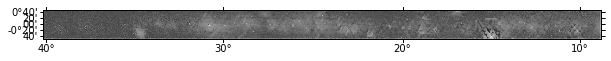

In [8]:
plt.figure(figsize=[10, 5])
ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
rmedian = np.median(img_array)
rrms = np.median(np.abs(img_array-rmedian))*1.486
print("rmedian",rmedian,"rrms",rrms)
ax1.imshow(np.arcsinh((img_array-rmedian)/rrms), origin='lower', cmap='gray')

In [9]:
t0 = time.time()
wiselist = glob.glob('wise*.fits*')
wimg_array = np.zeros((ny,nx),dtype=np.float)
wimg_count = np.zeros((ny,nx),dtype=np.int)
for wisefile in tqdm(wiselist):
    wisehdu = io.fits.open(wisefile)
    fast_reproject_interp(wisehdu['clean image'], hduimg.header,
                                            wimg_array, wimg_count, verbose=True)
wimg_array = wimg_array/wimg_count.clip(1)

print("Completed in {:.0f} s".format(time.time()-t0))

  0%|          | 0/6 [00:00<?, ?it/s]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(279.89176562, -26.0602757 ), (279.36992111, -13.6920167 ),
     (266.1065278 , -26.06019428), (266.62849931, -13.69197614)]>
xcorn [56383.02293261 37475.51361531 66823.22932231 47915.744608  ]
ycorn [-14951.65291915  -4264.37549665   4546.72573172  15233.91544609]
x1 x2 37474 55799 y1 y2 0 2879
wok 43776198


 17%|█▋        | 1/6 [01:21<06:46, 81.24s/it]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(276.44276133, -16.12748897), (276.20152657,  -3.75182133),
     (263.55564133, -16.12744083), (263.79693494,  -3.75181041)]>
xcorn [43677.1423948  24233.42899326 54181.32329339 34737.63586685]
ycorn [-1769.59518005  8980.91459508 17524.66754883 28275.09002531]
x1 x2 24232 54183 y1 y2 0 2879
wok 21773575


 33%|███▎      | 2/6 [03:43<06:38, 99.61s/it]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(286.44276133, -16.12748897), (286.20152657,  -3.75182133),
     (273.55564133, -16.12744083), (273.79693494,  -3.75181041)]>
xcorn [35827.33529441 16069.40077499 46007.57851905 26249.67182881]
ycorn [-17134.71412515  -6977.57247355   2631.32350613  12788.37821225]
x1 x2 16068 46009 y1 y2 0 2879
wok 72051582


 50%|█████     | 3/6 [05:56<05:28, 109.43s/it]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(286.2246136 , -6.1882018 ), (286.2246136 ,  6.18973704),
     (273.77384227, -6.18818375), (273.77384227,  6.18971898)]>
xcorn [19962.78851855   386.10757536 30143.07783976 10566.42419883]
ycorn [-8986.60965698  1153.11247073 10779.40429888 20919.03953187]
x1 x2 385 30145 y1 y2 0 2879
wok 69813587


 67%|██████▋   | 4/6 [08:11<03:54, 117.21s/it]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(296.2246136 , -6.1882018 ), (296.2246136 ,  6.18973704),
     (283.77384227, -6.18818375), (283.77384227,  6.18971898)]>
xcorn [12368.37622597 -7208.28265063 21915.40489226  2338.7751578 ]
ycorn [-24723.61796754 -14583.85011382  -5086.40744023   5053.27389274]
x1 x2 0 21917 y1 y2 0 2879
wok 25060547


 83%|████████▎ | 5/6 [09:37<01:47, 107.96s/it]

output size 55800 2880 input size 8000 8000
coords  <SkyCoord (ICRS): (ra, dec) in deg
    [(296.2015556 ,  3.75335629), (296.44279265, 16.12902391),
     (283.79690591,  3.75334537), (283.55561   , 16.12897577)]>
xcorn [ -3439.32125211 -21940.19722145   6107.75334558 -12393.0966077 ]
ycorn [-16618.20492323  -6205.32397147   3018.98205271  13431.7756903 ]
x1 x2 0 6109 y1 y2 0 2879
wok 15269253


100%|██████████| 6/6 [10:02<00:00, 83.02s/it] 


Completed in 607 s


wmedian 2088.611663013299 wrms 953.3483269215869


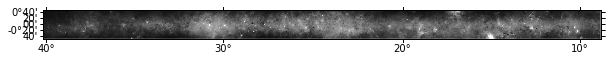

In [10]:
plt.figure(figsize=[10, 5])
ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
print("wmedian",wmedian,"wrms",wrms)
ax1.imshow(np.arcsinh((wimg_array-wmedian)/wrms), origin='lower', cmap='gray')

In [11]:
color_array = np.zeros([ny, nx, 3])
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
rrms = np.median(np.abs(img_array))*1.486
print("WISE rms",wrms,"Radio rms",rrms)
# color_array[:, :, 0] = np.arcsinh(arraywise/wrms)/np.arcsinh(arraywise.max()/wrms)
# color_array[:, :, 2] = (np.arcsinh(img_array/rrms)/np.arcsinh(img_array.max()/rrms)).clip(0.0)
# clip negative pixels at -5 sigma
clipval = np.arcsinh(-5.0)
rr = np.arcsinh((wimg_array-wmedian)/wrms).clip(clipval)
color_array[:, :, 0] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh(img_array/rrms).clip(clipval)
color_array[:, :, 2] = (rr-rr.min())/(rr.max()-rr.min())
color_array[:, :, 1] = np.mean(color_array[:,:,::2],axis=-1)

WISE rms 953.3483269215869 Radio rms 0.0005942464001248171


## Get GLIMPSE 8.0 $\mu$m Data

In [12]:
gtab = ascii.read('gpsglimpse80_fldinfo.list')
print(gtab)

 Name  UserID Dsk Cat#     Long       Lat       NX   NY   PixSize   Freq
------ ------ --- ---- ----------- ---------- ----- ---- ---------- ----
119-02    117   4    1 12.00027778 0.00027778 11000 3600 2.00000005 -1.0
171-02    117   4    2 17.00027778 0.00027778 11000 3600 2.00000005 -1.0
219-02    117   4    3 22.00027778 0.00027778 11000 3600 2.00000005 -1.0
271-02    117   4    4 27.00027778 0.00027778 11000 3600 2.00000005 -1.0
319-02    117   4    5 32.00027778 0.00027778 11000 3600 2.00000005 -1.0
 G371D    117   4    6 37.10027625 0.00027778 11000 3600 2.00000005 -1.0
 G419D    117   4    7  41.9002793 0.00027778 11000 3600 2.00000005 -1.0
 G471D    117   4    8 47.10027625 0.00027778 11000 3600 2.00000005 -1.0
  G51D    117   4    9 50.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G54D    117   4   10 53.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G57D    117   4   11 56.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G60D    117   4   12 59.99983333 0.00016667  9320

In [13]:
gls = (gtab['Long'].data)
gbs = (gtab['Lat'].data)
print(gbs)
print(gls)

[0.00027778 0.00027778 0.00027778 0.00027778 0.00027778 0.00027778
 0.00027778 0.00027778 0.00016667 0.00016667 0.00016667 0.00016667
 0.00016667]
[12.00027778 17.00027778 22.00027778 27.00027778 32.00027778 37.10027625
 41.9002793  47.10027625 50.99983333 53.99983333 56.99983333 59.99983333
 62.99983333]


In [14]:
t0 = time.time()
#ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
gimg_array = np.zeros((ny,nx),dtype=np.float)
gimg_count = np.zeros((ny,nx),dtype=np.int)
for j, b in enumerate(tqdm(gbs)):
    l = gls[j]
    fn = 'https://third.ucllnl.org/cgi-bin/gpsimage?RA={}&Dec={}&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1'.format(l,b)
    print(fn)
    image_file = download_file(fn, cache=True, timeout=300.0)
    glimpsehdu = io.fits.open(image_file)
    fast_reproject_interp(glimpsehdu[0], hduimg.header, gimg_array, gimg_count)
    glimpsehdu.close()
gimg_array = gimg_array/gimg_count.clip(1)
print("Completed in {:.0f} s".format(time.time()-t0))

  0%|          | 0/13 [00:00<?, ?it/s]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


  8%|▊         | 1/13 [00:33<06:39, 33.29s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


 15%|█▌        | 2/13 [01:03<05:57, 32.46s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


 23%|██▎       | 3/13 [01:35<05:21, 32.19s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


 31%|███       | 4/13 [02:06<04:46, 31.81s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


 38%|███▊      | 5/13 [02:36<04:09, 31.24s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.10027625&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


 46%|████▌     | 6/13 [03:04<03:33, 30.45s/it]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.9002793&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


100%|██████████| 13/13 [03:11<00:00, 14.75s/it]


https://third.ucllnl.org/cgi-bin/gpsimage?RA=47.10027625&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=50.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=53.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=56.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1
No overlap between input and output images
x1 x2 0 0 y1 y2 0 2879 out nx ny 55800 2880
https://third.ucllnl.org/cgi-bin/gpsimage?RA=59.9998

In [15]:
color_array = np.zeros([ny, nx, 3])
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
rrms = np.median(np.abs(img_array))*1.486
gmedian = np.median(gimg_array)
grms = np.median(np.abs(gimg_array-gmedian))*1.486
print("WISE rms",wrms,"Radio rms",rrms,"GLIMPSE rms",grms)
# color_array[:, :, 0] = np.arcsinh(arraywise/wrms)/np.arcsinh(arraywise.max()/wrms)
# color_array[:, :, 2] = (np.arcsinh(img_array/rrms)/np.arcsinh(img_array.max()/rrms)).clip(0.0)
# clip negative pixels at -5 sigma
clipval = np.arcsinh(-5.0)
rr = np.arcsinh((wimg_array-wmedian)/wrms).clip(clipval)
color_array[:, :, 0] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh((gimg_array-gmedian)/grms).clip(clipval)
color_array[:, :, 1] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh(img_array/rrms).clip(clipval)
color_array[:, :, 2] = (rr-rr.min())/(rr.max()-rr.min())

WISE rms 953.3483269215869 Radio rms 0.0005942464001248171 GLIMPSE rms 27.871717628992982


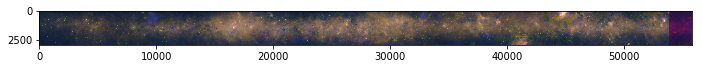

In [16]:
plt.figure(figsize=[12, 12.*color_array.shape[0]/color_array.shape[1]])
plt.imshow(color_array)

In [17]:
img = Image.fromarray(np.uint8(color_array*255), 'RGB')

In [18]:
img.save('test3.png')

Lupton et al. 2004 scaling

WISE rms 953.35 Radio rms 0.00059425 GLIMPSE rms 27.872
max 1830.99 233.25 26.15
99% 5.72 4.57 3.97
Completed in 201 s


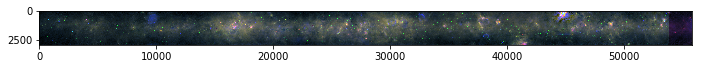

In [20]:
t0=time.time()
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
rmedian = np.median(img_array)
rrms = np.median(np.abs(img_array))*1.486
gmedian = np.median(gimg_array)
grms = np.median(np.abs(gimg_array-gmedian))*1.486
print("WISE rms {:.5} Radio rms {:.5} GLIMPSE rms {:.5}".format(wrms,rrms,grms))

wscale = ((wimg_array-wmedian)/wrms).clip(-5.0)
gscale = ((gimg_array-gmedian)/grms).clip(-5.0)
rscale = ((img_array)/rrms).clip(-5.0)
# use 99% quantiles for band scaling
wmin, w99, wmax = np.quantile(wscale,[0.0,0.99,1.0])
gmin, g99, gmax = np.quantile(gscale,[0.0,0.99,1.0])
rmin, r99, rmax = np.quantile(rscale,[0.0,0.99,1.0])
print('max {:.2f} {:.2f} {:.2f}'.format(rmax,gmax,wmax))
print('99% {:.2f} {:.2f} {:.2f}'.format(r99,g99,w99))

wscale = (wscale-wmin)/(w99-wmin)
gscale = (gscale-gmin)/(g99-gmin)
rscale = (rscale-rmin)/(r99-rmin)
lupton_i = (wscale+gscale+rscale)/3.0

# noise in lupton_i after scaling
sig_i = np.sqrt(1./(w99-wmin)**2 + 1./(g99-gmin)**2 + 1./(r99-rmin)**2)/3.0

xx = np.arcsinh(lupton_i/sig_i)
# use 99.9% quantiles for intensity scaling
xxmin, xx99 = np.quantile(xx,[0.001,0.999])
f_lupi = ((xx-xxmin)/(xx99-xxmin)).clip(0,1)

lupton_array = np.zeros([img_array.shape[0], img_array.shape[1], 3])
lupton_array[:, :, 0] = (f_lupi*wscale/lupton_i).clip(0,1)
lupton_array[:, :, 1] = (f_lupi*gscale/lupton_i).clip(0,1)
lupton_array[:, :, 2] = (f_lupi*rscale/lupton_i).clip(0,1)

plt.figure(figsize=[12, 12.*color_array.shape[0]/color_array.shape[1]])
plt.imshow(lupton_array)

img = Image.fromarray(np.uint8(lupton_array*255), 'RGB')
img.save('lupton3.png')
print("Completed in {:.0f} s".format(time.time()-t0))